In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
!pip install contractions
!pip install bert-tensorflow==1.0.1
!pip install tqdm
!pip install tensorflow_hub

     |████████████████████████████████| 321 kB 37.4 MB/s 
     |████████████████████████████████| 283 kB 56.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85454 sha256=4a7249c85ebf8f7554beb210aae8bb6a5fbddcf7b35793362727f7e5af64f12a
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 67 kB 6.0 MB/s 


In [ ]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

     |████████████████████████████████| 412.3 MB 13 kB/s 
     |████████████████████████████████| 3.8 MB 32.0 MB/s 
     |████████████████████████████████| 503 kB 63.2 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7553 sha256=8feb8ca55c1e7c32ea664f13ac33af7a2a6fccebf9a5c5147304d14616f51cd2
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tqdm
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from bert.tokenization import FullTokenizer

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [ ]:
import random
np.random.seed(42)
tf.set_random_seed(42)

In [ ]:
def get_df(file):
    return pd.read_csv(file, sep='\t', error_bad_lines= False)

In [ ]:
train_df = get_df('/content/drive/MyDrive/BTP/posts.txt')
test_df = get_df('/content/drive/MyDrive/BTP/posts_groundtruth.txt')

## Data Visualization

In [ ]:
train_df

,post_id,post_text,user_id,image_id(s),username,timestamp,label
0,324597532548276224,Don't need feds to solve the #bostonbombing wh...,886672620,"boston_fake_03,boston_fake_35",SantaCruzShred,Wed Apr 17 18:57:37 +0000 2013,fake
1,325145334739267584,PIC: Comparison of #Boston suspect Sunil Tripa...,21992286,boston_fake_23,Oscar_Wang,Fri Apr 19 07:14:23 +0000 2013,fake
2,325152091423248385,I'm not completely convinced that it's this Su...,16428755,boston_fake_34,jamwil,Fri Apr 19 07:41:14 +0000 2013,fake
3,324554646976868352,Brutal lo que se puede conseguir en colaboraci...,303138574,"boston_fake_03,boston_fake_35",rubenson80,Wed Apr 17 16:07:12 +0000 2013,fake
4,324315545572896768,4chan and the bombing. just throwing it out th...,180460772,boston_fake_15,Slimlenny,Wed Apr 17 00:17:06 +0000 2013,fake
...,...,...,...,...,...,...,...
15624,578433150071775232,Un présentateur de la ZDF confesse avoir truqu...,257551211,varoufakis_1,Cdt_Sylvestre,Thu Mar 19 05:49:44 +0000 2015,fake
15625,578433646597656576,"Oh les kleine menteurs \""@CorineBarella: Un pr...",27575883,varoufakis_1,damomarc,Thu Mar 19 05:51:42 +0000 2015,fake
15626,578486910491996160,Este es el programa de ZDF en el que confirman...,2049211,varoufakis_1,javierpascual,Thu Mar 19 09:23:21 +0000 2015,fake
15627,578505023912591360,11.34 - wir haben FAST Mittag ▶ Riesen Verwirr...,262222386,varoufakis_1,aotto1968_2,Thu Mar 19 10:35:20 +0000 2015,fake


In [ ]:
test_df

,post_id,post_text,user_id,username,image_id,timestamp,label
0,651118294447951872,"#AntiTerror ""#ArabianBlood"" #RussianFederation...",3.834097e+08,AlexArtAndros,airstrikes_1,Mon Oct 05 19:34:33 +0000 2015,fake
1,651115824065830912,"#АнтиТеррор ""#АрабскаяКровь"" #РФ в #Сирии прот...",3.834097e+08,AlexArtAndros,airstrikes_1,Mon Oct 05 19:24:44 +0000 2015,fake
2,651095856662360065,"Ну чё, сегодня надавали трендюлей игиловцам по...",2.712310e+09,NataYaraya,airstrikes_1,Mon Oct 05 18:05:23 +0000 2015,fake
3,651086828234104832,Действия России в Сирии безукоризненны. Видео...,3.690572e+07,Alltecz,airstrikes_1,Mon Oct 05 17:29:31 +0000 2015,fake
4,651034616007106560,5-10-2015\nThe airstrike against an ISIS ammun...,1.070959e+09,msojormsojor,airstrikes_1,Mon Oct 05 14:02:02 +0000 2015,fake
...,...,...,...,...,...,...,...
2172,700662094107119616,14 children! 14 different fathers! All of them...,6.973105e+07,ErrBodyLuvsCris,woman_14_children_1,Fri Feb 19 12:43:55 +0000 2016,fake
2173,700638809155710977,Meet The Woman Who Has Given Birth To 14 Child...,4.912947e+09,EyoawansBlog,woman_14_children_1,Fri Feb 19 11:11:23 +0000 2016,fake
2174,700618091886047232,"RT @Viasat1Ghana: Woman, 36, gives birth to 14...",3.245410e+08,NanaEssilfie,woman_14_children_1,Fri Feb 19 09:49:04 +0000 2016,fake
2175,700569502874992640,Woman Breaks World Record With 14 Children fro...,4.068154e+08,Abiola_j360ent,woman_14_children_2,Fri Feb 19 06:36:00 +0000 2016,fake


In [ ]:
def return_first_image(row):
    return row['image_id(s)'].split(',')[0].strip()

train_df['first_image_id'] = train_df.apply (lambda row: return_first_image(row),axis=1)
train_df

,post_id,post_text,user_id,image_id(s),username,timestamp,label,first_image_id
0,324597532548276224,Don't need feds to solve the #bostonbombing wh...,886672620,"boston_fake_03,boston_fake_35",SantaCruzShred,Wed Apr 17 18:57:37 +0000 2013,fake,boston_fake_03
1,325145334739267584,PIC: Comparison of #Boston suspect Sunil Tripa...,21992286,boston_fake_23,Oscar_Wang,Fri Apr 19 07:14:23 +0000 2013,fake,boston_fake_23
2,325152091423248385,I'm not completely convinced that it's this Su...,16428755,boston_fake_34,jamwil,Fri Apr 19 07:41:14 +0000 2013,fake,boston_fake_34
3,324554646976868352,Brutal lo que se puede conseguir en colaboraci...,303138574,"boston_fake_03,boston_fake_35",rubenson80,Wed Apr 17 16:07:12 +0000 2013,fake,boston_fake_03
4,324315545572896768,4chan and the bombing. just throwing it out th...,180460772,boston_fake_15,Slimlenny,Wed Apr 17 00:17:06 +0000 2013,fake,boston_fake_15
...,...,...,...,...,...,...,...,...
15624,578433150071775232,Un présentateur de la ZDF confesse avoir truqu...,257551211,varoufakis_1,Cdt_Sylvestre,Thu Mar 19 05:49:44 +0000 2015,fake,varoufakis_1
15625,578433646597656576,"Oh les kleine menteurs \""@CorineBarella: Un pr...",27575883,varoufakis_1,damomarc,Thu Mar 19 05:51:42 +0000 2015,fake,varoufakis_1
15626,578486910491996160,Este es el programa de ZDF en el que confirman...,2049211,varoufakis_1,javierpascual,Thu Mar 19 09:23:21 +0000 2015,fake,varoufakis_1
15627,578505023912591360,11.34 - wir haben FAST Mittag ▶ Riesen Verwirr...,262222386,varoufakis_1,aotto1968_2,Thu Mar 19 10:35:20 +0000 2015,fake,varoufakis_1


In [ ]:
train_df['label'].value_counts()

fake    9404
real    6225
Name: label, dtype: int64

In [ ]:
test_df['label'].value_counts()

fake    1186
real     991
Name: label, dtype: int64

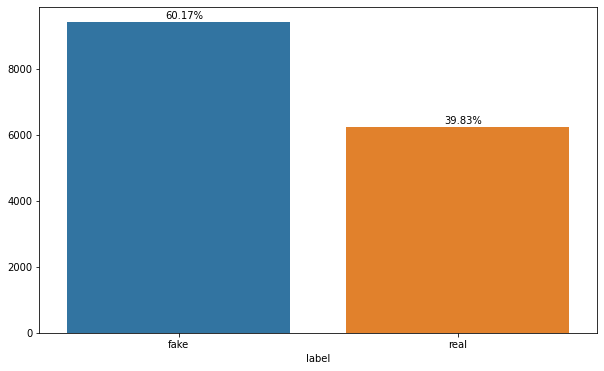

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sns.countplot(x='label', data=train_df)

ax.set_xlabel('label')
ax.set_ylabel('')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/train_df.shape[0]*100), (p.get_x()+0.35, p.get_height()+100))

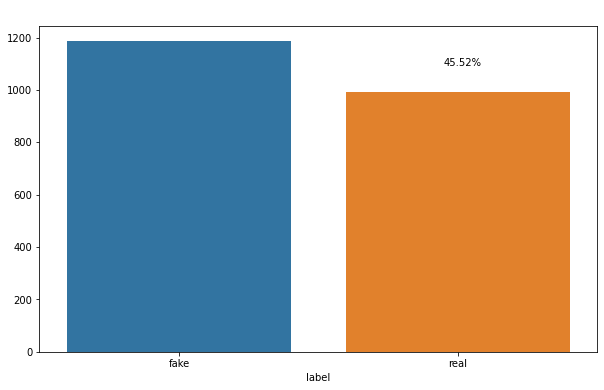

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sns.countplot(x='label', data=test_df)

ax.set_xlabel('label')
ax.set_ylabel('')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/test_df.shape[0]*100), (p.get_x()+0.35, p.get_height()+100))

In [ ]:
image_train_df = get_df('/content/drive/MyDrive/BTP/images.txt')
image_train_df

b'Skipping line 165: expected 4 fields, saw 5\n'


,image_id,image_url,annotation,event
0,boston_fake_01,http://i.imgur.com/LvoCC5T.jpg,fake,boston
1,boston_fake_02,http://instagram.com/p/YN7_ThPXrU/,fake,boston
2,boston_fake_03,https://o.twimg.com/2/proxy.jpg?t=HBgeaHR0cDov...,fake,boston
3,boston_fake_04,http://media.tumblr.com/a813460e72a178d8127b50...,fake,boston
4,boston_fake_05,http://i.imgur.com/uxAh4wwh.jpg,fake,boston
...,...,...,...,...
355,livr_02,https://pbs.twimg.com/media/Bic4fA5CQAAT5KY.jpg,Livr,NaN
356,livr_03,https://pbs.twimg.com/media/BialJuECIAATXE2.jpg,Livr,NaN
357,livr_04,https://pbs.twimg.com/media/BiVisqpCIAAbgju.jpg,Livr,NaN
358,passport_01,https://pbs.twimg.com/media/Bo-CY5ACcAAiRAw.jpg,Passport,NaN


In [ ]:
images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train = [i.split('.')[0].strip() for i in os.listdir('/content/drive/MyDrive/BTP/Images')]
images_NA = set(images_train_dataset)-set(images_train)
images_NA

{'boston_fake_03',
 'boston_fake_07',
 'boston_fake_10',
 'boston_fake_13',
 'boston_fake_20',
 'boston_fake_35',
 'eclipse_08',
 'eclipse_video_01',
 'livr_02',
 'malaysia_fake_02',
 'sandy_fake_08',
 'sandy_fake_21',
 'sandy_real_121',
 'sandy_real_128',
 'sandy_real_129',
 'sandy_real_134',
 'sandy_real_139',
 'sandy_real_141',
 'sandy_real_147',
 'sandy_real_149',
 'sandy_real_36',
 'sandy_real_4',
 'sandy_real_53',
 'sandy_real_6',
 'sandy_real_92',
 'syrianboy_1',
 'varoufakis_1'}

In [ ]:
train_df = train_df[~train_df['first_image_id'].isin(images_NA)]
train_df.shape

(13241, 8)

In [ ]:
images_test_dataset = [i for i in test_df['image_id'].tolist()]
images_test = [i.split('.')[0].strip() for i in os.listdir('/content/drive/MyDrive/BTP/TestSet_Images')]
images_test_NA = set(images_test_dataset)-set(images_test)
images_test_NA

{'airstrikes_1',
 'american_soldier_quran_1',
 'ankara_explosions_1',
 'ankara_explosions_2',
 'ankara_explosions_3',
 'attacks_paris_16',
 'attacks_paris_24',
 'attacks_paris_7',
 'boko_haram_1',
 'brussels_car_metro_1',
 'brussels_car_metro_2',
 'brussels_car_metro_3',
 'brussels_explosions_1',
 'brussels_explosions_2',
 'brussels_explosions_3',
 'convoy_explosion_turkey_1',
 'convoy_explosion_turkey_2',
 'convoy_explosion_turkey_3',
 'donald_trump_attacker_1',
 'eagle_kid_1',
 'isis_children_1',
 'isis_children_2',
 'pope_francis_1',
 'snowboard_girl_1',
 'snowboard_girl_2',
 'syrian_children_2'}

In [ ]:
test_df = test_df[~test_df['image_id'].isin(images_test_NA)]
test_df.shape

(1098, 7)

## **Textual Feature Extraction**

In [ ]:
train_text = train_df['post_text'].tolist()
test_text = test_df['post_text'].tolist()
len(train_text)

13241

In [ ]:
y_train = train_df['label'].tolist()
y_train = [1 if i=='real' else 0 for i in y_train]

y_test = test_df['label'].tolist()
y_test = [1 if i=='real' else 0 for i in y_test]

## Data Pre-processing

In [ ]:
import unicodedata
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

   # Removing @mention
    sentence = re.sub(r'@[A-Za-z0-9]+','',sentence)

    # Removing Url linking
    sentence = re.sub('https?://[A-Za-z0-9./]+','',sentence)

    # Removing hashtags and numbers
    sentence = re.sub("[^a-zA-Z^']", " ", sentence)
   
    return sentence

In [ ]:
import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

text = []
sentences = train_text
for sen in sentences:
    text.append(preprocess_text(sen))

train_text= text
train_text[0]

"PIC  Comparison of  Boston suspect Sunil Tripathi's FBI released images video and his MISSING poster  You decide "

In [ ]:
import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

text = []
sentences = test_text
for sen in sentences:
    text.append(preprocess_text(sen))

test_text= text
test_text[0]

'Tristesse       n Bataclan sold out  musiciens  amp  public en osmose   Quelques minutes avant le drame   paixauxvictimes '

In [ ]:
def max_length(lines):
    return max([len(s.split()) for s in lines])

print("maximum length:", max_length(train_text))

maximum length: 28


In [ ]:
max_seq_length = 25

## BERT InputExamples

In [ ]:
class PaddingInputExample(object):
  pass

class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):
    
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

## BERT Tokenization

In [ ]:
def create_tokenizer_from_hub_module():
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

## Input Feature Extractor

In [ ]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

In [ ]:
sess = tf.Session()
tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Convert Text data to BERT Input Features

In [ ]:
from tqdm import tqdm_notebook
train_examples = convert_text_to_examples(train_text, y_train)
test_examples = convert_text_to_examples(test_text, y_test)

(train_input_ids, train_input_masks, train_segment_ids, y_train
 ) =  convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)

(test_input_ids, test_input_masks, test_segment_ids, y_test
 ) =  convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Loading BERT Model

In [ ]:
bm = hub.Module(bert_path, trainable=True, name=f"bert_module")
bm

In [ ]:
len(bm.variables)

204

In [ ]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )

        trainable_vars = self.bert.variables

        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]

        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
            
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

## BERT Classifier Model Architecture

In [ ]:
def initialize_vars(sess):
    sess = tf.Session()
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

## Training BERT Classifier

## Evaluating Model Performance

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report

# print('Classification Report:')
# print(classification_report(y_true=y_test, y_pred=test_pred_labels))

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# %matplotlib inline

# with tf.Session() as session:
#     cm = tf.confusion_matrix(y_test, test_pred_labels).eval()

# LABELS = ['negative', 'positive']
# sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
# xl = plt.xlabel("Prediction")
# yl = plt.ylabel("Ground truth")

## **Image Feature Extraction**

In [ ]:
train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['image_id'].tolist()]
len(test_images)

1098

In [ ]:
images = os.listdir('/content/drive/MyDrive/BTP/Images')
images.extend(os.listdir('/content/drive/MyDrive/BTP/TestSet_Images'))
jpg = []
png=[]
jpeg=[]
gif = []

for i in images:
    name,ext = i.split('.')[0],i.split('.')[-1]
    eval(ext).append(name)

In [ ]:
def extension_of_file(file_name):
    if file_name in jpg:
        return '.jpg'
    elif file_name in png:
        return '.png'
    elif file_name in jpeg:
        return '.jpeg'
    else:
        return '.gif'

In [ ]:
sample= os.listdir('/content/drive/MyDrive/BTP/Images/')

train_images=['/content/drive/MyDrive/BTP/Images/'+i+extension_of_file(i) for i in train_images]

len(train_images)

13241

In [ ]:
len(train_images)

13241

In [ ]:
sample= os.listdir('/content/drive/MyDrive/BTP/TestSet_Images/')

test_images=['/content/drive/MyDrive/BTP/TestSet_Images/'+i+extension_of_file(i) for i in test_images]

len(test_images)

1098

In [ ]:
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
from tqdm import tqdm_notebook
def image_processing(list_of_images):
  X = [] 
  for image in tqdm(list_of_images):
      # im = cv2.imread(image, cv2.IMREAD_COLOR)
      # if type(im) is np.ndarray:
      #   if im.size == 0:
      #     continue
      # if im is None:
      #   continue
   X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (224,224), interpolation=cv2.INTER_CUBIC))  
  return X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
train_imagesX = image_processing(train_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
test_imagesX = image_processing(test_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
len(train_imagesX)

13241

In [ ]:
np.save('train_imagesX.npy', train_imagesX)
np.save('test_imagesX.npy', test_imagesX)

In [ ]:
train_imagesX = np.load('train_imagesX.npy')
test_imagesX = np.load('test_imagesX.npy')

In [ ]:
train_imagesX

array([[[[148, 157, 160],
         [149, 156, 159],
         [149, 156, 159],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[148, 157, 160],
         [149, 156, 159],
         [149, 156, 159],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[148, 157, 160],
         [149, 156, 159],
         [149, 156, 159],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

In [ ]:
test_imagesX

array([[[[ 30,  23,  28],
         [ 29,  21,  28],
         [ 29,  20,  29],
         ...,
         [ 69,  68, 102],
         [ 71,  70, 108],
         [ 79,  78, 118]],

        [[ 31,  20,  35],
         [ 30,  20,  34],
         [ 29,  19,  33],
         ...,
         [ 32,  31,  65],
         [ 28,  28,  65],
         [ 48,  47,  87]],

        [[ 29,  15,  39],
         [ 32,  20,  41],
         [ 32,  20,  39],
         ...,
         [ 44,  42,  77],
         [ 34,  34,  70],
         [ 83,  82, 123]],

        ...,

        [[ 42,  35,  57],
         [ 35,  28,  49],
         [ 29,  22,  48],
         ...,
         [221, 186, 133],
         [248, 219, 161],
         [255, 233, 172]],

        [[ 38,  28,  57],
         [ 43,  33,  60],
         [ 36,  26,  52],
         ...,
         [108,  56,  10],
         [112,  67,  14],
         [125,  86,  26]],

        [[ 31,  20,  53],
         [ 41,  30,  59],
         [ 51,  39,  64],
         ...,
         [212, 141,  99],
        

In [ ]:
train_images_fin = np.rollaxis(train_imagesX, 3, 1)
train_images_fin

array([[[[148, 149, 149, ..., 255, 255, 255],
         [148, 149, 149, ..., 255, 255, 255],
         [148, 149, 149, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],

        [[157, 156, 156, ..., 255, 255, 255],
         [157, 156, 156, ..., 255, 255, 255],
         [157, 156, 156, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],

        [[160, 159, 159, ..., 255, 255, 255],
         [160, 159, 159, ..., 255, 255, 255],
         [160, 159, 159, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]]],


       [[[ 27,  24,  18, ...,  48,  40,  60],
         [ 24,  22,  17, ...,  49,  41,  55],
         [ 23,  21,  17, ..., 

In [ ]:
test_images_fin = np.rollaxis(test_imagesX,3,1)
test_images_fin

array([[[[ 30,  29,  29, ...,  69,  71,  79],
         [ 31,  30,  29, ...,  32,  28,  48],
         [ 29,  32,  32, ...,  44,  34,  83],
         ...,
         [ 42,  35,  29, ..., 221, 248, 255],
         [ 38,  43,  36, ..., 108, 112, 125],
         [ 31,  41,  51, ..., 212, 217, 225]],

        [[ 23,  21,  20, ...,  68,  70,  78],
         [ 20,  20,  19, ...,  31,  28,  47],
         [ 15,  20,  20, ...,  42,  34,  82],
         ...,
         [ 35,  28,  22, ..., 186, 219, 233],
         [ 28,  33,  26, ...,  56,  67,  86],
         [ 20,  30,  39, ..., 141, 154, 167]],

        [[ 28,  28,  29, ..., 102, 108, 118],
         [ 35,  34,  33, ...,  65,  65,  87],
         [ 39,  41,  39, ...,  77,  70, 123],
         ...,
         [ 57,  49,  48, ..., 133, 161, 172],
         [ 57,  60,  52, ...,  10,  14,  26],
         [ 53,  59,  64, ...,  99, 104, 111]]],


       [[[ 30,  29,  29, ...,  69,  71,  79],
         [ 31,  30,  29, ...,  32,  28,  48],
         [ 29,  32,  32, ..., 

# SPOTFAKE MODEL

In [ ]:
from tensorflow.keras import backend as K
import gc
def spotfake_model( params):
    
  K.clear_session()
  
  bert_base = BertLayer()
  bert_base.trainable= params['bert_trainable']

  in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
  in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
  in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
  bert_inputs = [in_id, in_mask, in_segment]
  bert_output = bert_base(bert_inputs)

  for i in range(params['text_no_hidden_layer']):
    bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
    bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

  text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)    #Tf
  
    #image model
  conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
  conv_base.trainable=False

  input_image = tf.keras.layers.Input(shape=(224,224,3))
  base_output = conv_base(input_image)
  flat = tf.keras.layers.Flatten()(base_output)

  for i in range(params['vis_no_hidden_layer']):
    flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
    flat = tf.keras.layers.Dropout(params['dropout'])(flat)

  visual_repr = tf.keras.layers.Dense(params['repr_size'],activation='relu')(flat)        #Vf


  #classifier
  combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
  com_drop=tf.keras.layers.Dropout(params['dropout'])(combine_repr)

  for i in range(params['final_no_hidden_layer']):
    com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
    com_drop=tf.keras.layers.Dropout(params['dropout'])(com_drop)
  
  prediction = tf.keras.layers.Dense(1,activation='sigmoid')(com_drop)

  model = tf.keras.models.Model(inputs=[in_id,in_mask,in_segment,input_image], outputs=prediction)

  model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
  initialize_vars(sess)
    
  return model

In [ ]:
params = {
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':tf.keras.optimizers.Adam
}

In [ ]:
model = spotfake_model(params=params)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


80142336/80134624 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 25)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 25)]         0                                            
______________________________________________________________________________________________

In [ ]:
len(train_input_ids), len(train_imagesX)

(13241, 13241)

In [ ]:
out = model.fit([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], y_train,
                    batch_size=256,
                    epochs=20,
                    verbose=1,
                    shuffle=True,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],y_test))

Train on 13241 samples, validate on 1098 samples
Epoch 1/20
13241/13241 [==============================] - 142s 11ms/sample - loss: 0.6569 - acc: 0.6240 - val_loss: 0.7080 - val_acc: 0.5073
Epoch 2/20
13241/13241 [==============================] - 114s 9ms/sample - loss: 0.5603 - acc: 0.6790 - val_loss: 0.7247 - val_acc: 0.4964
Epoch 3/20
13241/13241 [==============================] - 114s 9ms/sample - loss: 0.5323 - acc: 0.7021 - val_loss: 0.9121 - val_acc: 0.6239
Epoch 4/20
13241/13241 [==============================] - 114s 9ms/sample - loss: 0.4940 - acc: 0.7332 - val_loss: 0.7730 - val_acc: 0.6157
Epoch 5/20
13241/13241 [==============================] - 115s 9ms/sample - loss: 0.4796 - acc: 0.7407 - val_loss: 0.7232 - val_acc: 0.6047
Epoch 6/20
13241/13241 [==============================] - 114s 9ms/sample - loss: 0.4775 - acc: 0.7406 - val_loss: 0.7498 - val_acc: 0.5774
Epoch 7/20
13241/13241 [==============================] - 114s 9ms/sample - loss: 0.4733 - acc: 0.7438 - val_l

In [ ]:
test_predict = model.predict([test_input_ids, test_input_masks, test_segment_ids,test_imagesX])
test_predict = [1 if i>=0.5 else 0 for i in test_predict]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=test_predict))

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.86      0.75       630
           1       0.68      0.39      0.49       468

    accuracy                           0.66      1098
   macro avg       0.67      0.63      0.62      1098
weighted avg       0.67      0.66      0.64      1098



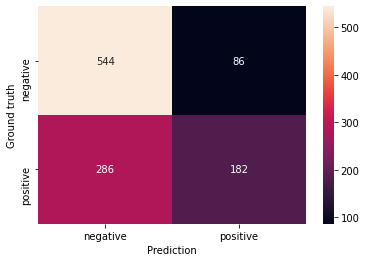

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(y_test, test_predict).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Prediction")
yl = plt.ylabel("Ground truth")